In [1]:
import pandas as pd
from sklearn import mixture
import numpy as np
import os

from matplotlib.colors import LogNorm

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans


import random
import datetime

import warnings
warnings.filterwarnings("ignore")


In [17]:
df=pd.read_csv('./Proj_Data/node.csv', index_col=0)
df.head()

,index,ID,q,k,v,Long,Lat
0,0,715898,410.684028,0.090358,62.457812,-118.021787,33.880183
1,3,715929,405.503472,0.154721,54.573437,-118.123095,33.971707
2,5,715933,383.663194,0.131772,56.324479,-118.130679,33.981839
3,6,715938,393.451389,0.137075,54.980208,-118.150997,34.002541
4,7,715944,381.265625,0.151283,56.689583,-118.166091,34.013676


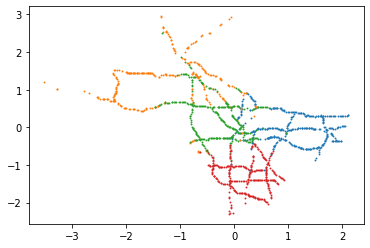

In [38]:
n_clusters = 4
input_feature = ['Long','Lat','q']  # with spatial information, but no connectivity
km_cluster = KMeans(n_clusters=n_clusters, max_iter=500, init='k-means++')


X_train_km_cluster = df[input_feature]   
# 
scaler_km_cluster = StandardScaler()
scaler_km_cluster.fit(X_train_km_cluster)

X_train_km_cluster= scaler_km_cluster.transform(X_train_km_cluster)
#
clf = km_cluster.fit(X_train_km_cluster) 

df['Kmeans'] =km_cluster.predict(X_train_km_cluster)
#
df_train_lt = []


# 
for n_ in range(n_clusters):
    df_train_n = df[df.Kmeans == n_]
    df_train_lt.append(df_train_n)
    
#
plt.figure()
result=clf.predict(X_train_km_cluster)  # partition result
for i in range(len(result)):
    plt.scatter(X_train_km_cluster[result==i,0],X_train_km_cluster[result==i,1],.8)


## next by K.Z.

In [27]:
df['cls'] = result

In [28]:
nodes = df.copy()
edges = pd.read_csv('Proj_Data/edges_with_qkv.csv', index_col=0)

In [29]:
data_new = pd.read_csv('./Proj_Data/2019-10-21_with_cord.csv', index_col=0)
data_new = data_new.loc[data_new['Lane type']=='ML']

In [30]:
data_new['cls'] = ''
for i in nodes.index:
    ID = nodes.loc[i, 'ID']
    cls = nodes.loc[i, 'cls']
    data_new.loc[data_new['ID']==ID, 'cls'] = cls
data_new['q0'] = data_new['q'] * 12
data_new['k0'] = data_new['q0'] / data_new['Avg v']

There are 4 classes


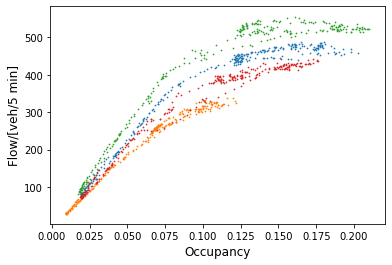

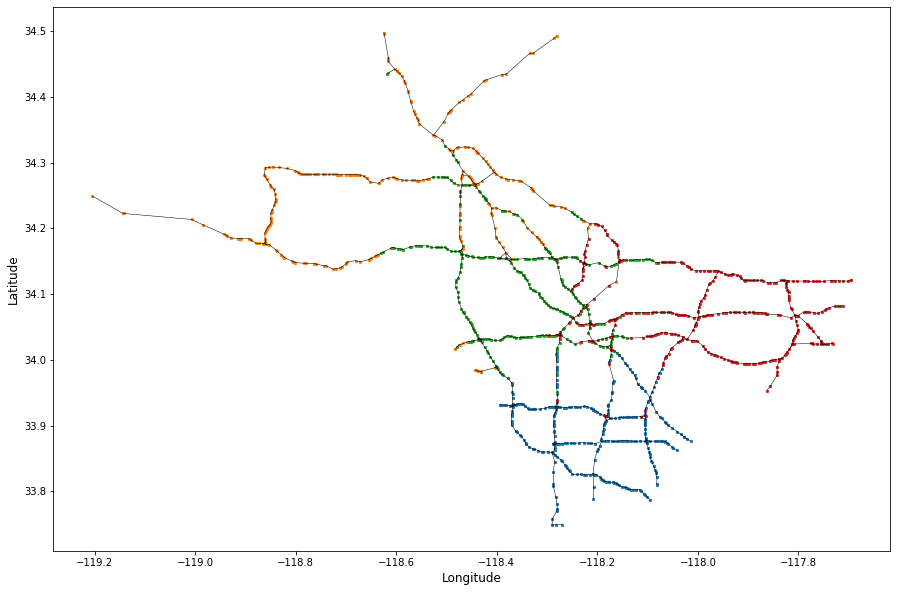

In [33]:
c = 0
c_set = []
color_set = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig_mfd = plt.figure()
ax_mfd = fig_mfd.add_subplot(111)
fig_net = plt.figure(figsize=[15,10])
ax_net = fig_net.add_subplot(111)

for i in edges.index:
    node1 = edges.loc[i, 'node1']
    node2 = edges.loc[i, 'node2']
    ax_net.plot([nodes.loc[node1, 'Long'], nodes.loc[node2, 'Long']], [nodes.loc[node1, 'Lat'], nodes.loc[node2, 'Lat']], 'black', lw=0.5)

for i in [3,0,1,2]:
    data_cls = data_new.loc[data_new['cls']==i].sort_values(by=['ID', 'Time'])
    q_cls = data_cls['q'].values
    if q_cls.reshape(-1, 288).shape[0] <= 1:
        continue
    q_cls_avg = q_cls.reshape(-1, 288).mean(axis=0)
    k_cls = data_cls['Avg k'].values
    k_cls_avg = k_cls.reshape(-1, 288).mean(axis=0)
    ax_mfd.scatter(k_cls_avg, q_cls_avg, s=.5, c=color_set[c])
    ax_mfd.set_xlabel('Occupancy', fontsize=12)
    ax_mfd.set_ylabel('Flow/[veh/5 min]', fontsize=12)
    
    lng = nodes.loc[nodes['cls']==i, 'Long']
    lat = nodes.loc[nodes['cls']==i, 'Lat']
    ax_net.scatter(lng, lat, s=5, c=color_set[c])
    ax_net.set_xlabel('Longitude', fontsize=12)
    ax_net.set_ylabel('Latitude', fontsize=12)
    c+=1
    c_set.append(i)
print('There are %i classes'%c)
fig_mfd.savefig('./img/kmeans_fig_mfd.svg', format='svg')
fig_net.savefig('./img/kmeans_fig_net.svg', format='svg')

fig_mfd.savefig('./img/kmeans_fig_mfd.png', dpi=500)
fig_net.savefig('./img/kmeans_fig_net.png', dpi=500)